In [15]:
#cell 1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cPickle as pickle
import math
import matplotlib.pyplot as plt
#import scipy.optimize
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.regression.linear_model import OLSResults
from statsmodels.regression.linear_model import OLS as ols
import scipy.stats as stat
from numpy import linalg as LA
from scipy.misc import comb
from pylab import *
from scipy.optimize import minimize
from scipy.optimize import basinhopping

pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 30)
pd.set_option('display.notebook_repr_html',True)
%matplotlib inline

In [16]:
fpath = r"/Users/dorisvoina/Desktop/Allen_Institute_stuff/avg_response_df.pkl"
f = open(fpath,'rb')
gpath = r"/Users/dorisvoina/Desktop/Allen_Institute_stuff/trial_df.pkl"
#g = open(gpath,'rb')
g = pd.read_pickle(gpath)
#df = pickle.load(g)

In [17]:
#cell 2
#open file with data -  actually there are two important files!
fpath = r"/Users/dorisvoina/Desktop/Allen_Institute_stuff/avg_response_df.pkl"
#f = open(fpath,'rb')

#dd = pickle.load(f)
dd = pd.read_pickle(fpath) 
    
gpath = r"/Users/dorisvoina/Desktop/Allen_Institute_stuff/trial_df.pkl"
#g = open(gpath,'rb')
#df = pickle.load(g)
df = pd.read_pickle(gpath)

df["total_trial_ind"] = np.arange(len(df))
dd.Image[dd.Image=="CoxImage1.png"] = "mushroom"
dd.Image[dd.Image=="CoxImage2.png"] = "bird"

df.Image[df.Image=="CoxImage1.png"] = "mushroom"
df.Image[df.Image=="CoxImage2.png"] = "bird"

sizes = np.sort(df.Size.unique())
orientations = np.sort(df.Ori.unique())

#for the purposes of the experiment, should be m=n=7
m = len(sizes)
n = len(orientations)

evenTest1 = isinstance((m/float(2)), (int, long))
evenTest2 = isinstance((n/float(2)), (int, long))
    
if evenTest1:
    s_T = sizes[m/2-1]
else:
    s_T = sizes[m/2]
        
if evenTest2:
    o_T = orientations[n/2-1]    
else:
    o_T = orientations[n/2]
    
s_max = sizes[m-1]
DataSize = len(df)

df.head()

/Users/dorisvoina/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dorisvoina/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dorisvoina/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dorisvoina/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value i

,Size,Image,Ori,PosY,trial,time,terraincode,pausetime,choice,selectiontime,istarget,speed,lapdistance,timebeforezone,slowing_f,mouse,date,total_trial_ind
0,400,bird,0,0,1,1.840244,53,0.267095,False,1,False,2152.301946,3937,0.099917,1.151120,M130587,2014-10-03 13:29:50.625000,0
1,550,bird,-15,0,2,3.024151,36,0.268031,False,1,False,2155.681332,2455,0.100434,0.995480,M130587,2014-10-03 13:29:50.625000,1
2,350,bird,0,0,3,4.273621,54,0.399960,False,1,False,1231.647159,2661,0.115117,1.148952,M130587,2014-10-03 13:29:50.625000,2
3,550,bird,45,0,4,7.623390,92,0.667990,False,1,False,1416.589407,4376,0.200129,11.667522,M130587,2014-10-03 13:29:50.625000,3
4,450,bird,0,0,5,12.638539,52,0.232075,False,1,False,2709.459253,3349,0.115528,0.995757,M130587,2014-10-03 13:29:50.625000,4


In [20]:
#cell 3
def firingRates(perceptual_params):

    #k_s = 0.00131
    #k_o = 0.0024
    #k_d = 0.0129
    #alpha = 0.368

    #parameters of the hill function
    k_s = perceptual_params[0]
    k_o = perceptual_params[1]
    k_d = perceptual_params[2]
    alpha = perceptual_params[3]

    firingRate_pref = 40 #firing rates
    firingRate_null = -20
    firingRate_baseline = 20
    x0=1

    c = np.zeros((len(orientations), len(sizes)))
    firingRate_preferred = np.zeros((len(orientations), len(sizes)))
    firingRate_unpreferred= np.zeros((len(orientations), len(sizes)))

    #hill function for each size and orientation
    for i,o in enumerate(orientations):
        for j,s in enumerate(sizes):
        
            c[i,j] = 1 - 0.5*1/(1+x0/(k_s*math.fabs(s-s_T)+k_o*math.fabs(o-o_T)+k_d*(s_max-s)+alpha))
        
            #right is mushroom, left is bird
            firingRate_preferred[i,j] = firingRate_pref*c[i,j] + firingRate_baseline
            firingRate_unpreferred[i,j] = firingRate_null*c[i,j] + firingRate_baseline
  
    return firingRate_preferred, firingRate_unpreferred

In [21]:
#cell 4
# empirical stop probabilities for mushrooms and birds and trials corresponding to different sizes, orientations, 
#and identity

def p_real():
    
    p_m_real = np.zeros((len(orientations),len(sizes)))
    p_b_real = np.zeros((len(orientations),len(sizes)))
    trials_tot = np.zeros((len(orientations),len(sizes)))
    trials_stop = np.zeros((len(orientations),len(sizes)))
    trials_m = np.zeros((len(orientations),len(sizes)))
    trials_b = np.zeros((len(orientations),len(sizes)))
    trials_stop_m = np.zeros((len(orientations),len(sizes)))
    trials_stop_b = np.zeros((len(orientations),len(sizes)))
    
    for ind2,o in enumerate(orientations):
        for ind1,s in enumerate(sizes):
                
            trials_tot[ind2,ind1] = len(df[(df.Size==s)&(df.Ori==o)].total_trial_ind)
            trials_stop[ind2,ind1] = len(df[(df.Size==s)&(df.Ori==o)&(df.choice==True)].total_trial_ind)
            
            trials_m[ind2,ind1] = len(df[(df.Size==s)&(df.Ori==o)&(df.Image=='mushroom')].total_trial_ind)
            trials_b[ind2,ind1] = len(df[(df.Size==s)&(df.Ori==o)&(df.Image=='bird')].total_trial_ind)   
            
            trials_stop_m[ind2,ind1] = len(df[(df.Size==s)&(df.Ori==o)&(df.Image=='mushroom')&(df.choice==True)].total_trial_ind)
            trials_stop_b[ind2,ind1] = len(df[(df.Size==s)&(df.Ori==o)&(df.Image=='bird')&(df.choice==True)].total_trial_ind)   
            
            p_m_real[ind2, ind1] = trials_m[ind2,ind1]/trials_tot[ind2,ind1]
            p_b_real[ind2, ind1] = trials_b[ind2,ind1]/trials_tot[ind2,ind1]   
     
    total = trials_tot.sum(axis=1).sum(axis=0)   
    
    return p_m_real, p_b_real, trials_tot, trials_stop, trials_m, trials_b, trials_stop_m, trials_stop_b, total

Next is the cell where the POMDP process is simulated. It takes a distance to target and perceptual parameters that determine the uncertainty (or c) and is modeled by a hill function, associated with the object to be identified

In [40]:
#cell 5
def Simulate_N_pomdp(distance, percept_params):
    
    #firing rates of neurons that respond to left/right, mushroom/bird
    firingRate_pref = 40
    firingRate_null = -20
    firingRate_baseline = 20

    n = 1 #how many observations/unit time to obtain, fixed to 1

    #k_o, k_s, k_d, alpha, x0 are parameters in the accumulator model,modeling the hill function 
    k_s = percept_params[0]
    k_o = percept_params[1]
    k_d = percept_params[2]
    alpha = percept_params[3]
    x0 = 1

    p_m_real, p_b_real, trials_tot, trials_stop, trials_m, trials_b, trials_stop_m, trials_stop_b, total = p_real()

    weighted_uncertainty = 0
    
    #compute uncertainty for each size, orientation and then compute weighed uncertainty
    for ind2, o in enumerate(orientations):
        for ind1, s in enumerate(sizes):

            uncertainty = 0.5*1/(1+x0/(k_s*math.fabs(s-s_T)+k_o*math.fabs(o-o_T)+k_d*(s_max-s)+alpha))
            c = 1-uncertainty
            weighted_uncertainty = weighted_uncertainty + c*trials_tot[ind2, ind1]/total 

    thresh = 0.02 #threshold of how close the distances have to be to think that the target is reached

    #mu_array = states between 0 and 1, denoting how sure we are if left or right (random dots task) OR mushroom and bird
    #denotes possible values of mu (degree of belief in left/right, mushroom/bird)
    
    mu_count = 25
    mu_array = np.linspace(1/mu_count, 1, mu_count, endpoint=True)

    #rewards for different outcomes: positive reward for true positive, rewardN_disappointment for false positive etc.
    #rewards 5, -2, -4, 0, -1
    rewardP = 20
    rewardN_disappointment = -20
    rewardN_missedOpportunity = -20
    rewardP_CR = 20
    rewardS = -1 #when sampling more

    #actions correspond to different velocities
    #v_min = 1
    #v_max = 5
    #velocities = np.linspace(v_min, v_max, 5, endpoint = True)
    #velocities = [0, velocities]
    velocities = [0,1,2] #3 possible actions corresponding to different velocities
    no_actions = len(velocities)

    [firingRate_preferred, firingRate_unpreferred] = firingRates(percept_params)
    sum_firingRates = firingRate_preferred + firingRate_unpreferred
    max_fR = sum_firingRates.max(axis=1).max()
    min_fR = sum_firingRates.min(axis=1).min()

    #discretize the distance to the target s.t. one increment of distance is small
    #distance_set is discrete set of distances to target; increment_dist is how many incremental distances there are
    distance_left_original = distance
    sigma = 0.001
    mean_fR = float(1/(max_fR))
    variance_fR = float((1/min_fR))**2
    incremental_d = velocities[1]*(mean_fR-variance_fR*5)
    increment_dist = (int)(math.ceil(distance_left_original/incremental_d))
    distance_set = np.linspace(0, distance_left_original+int(sigma*10), num = increment_dist)
    
    #initial value and policy function before learning; a state is determined by the evidence to Left/bird or Right/mushroom
    value = np.ones((increment_dist+20, increment_dist+20, increment_dist))
    policy = -np.ones((increment_dist+20, increment_dist+20, increment_dist))
    
    freq_visit = np.zeros((increment_dist+20, increment_dist+20, increment_dist)) #number of visits to a certain state

    alpha_TD = 0.1 #learning rate
    discount_factor = 1 #lambda

    incr = 0 #in a version of this simulation, some trials were not considered, so incr counts considered trials -- not important
    #trials = 1000
    trials = len(df)

    ###
    
    #some variables that store characteristics of the simulation: average jump time, number of jumps etc.
    tau_avg1 = 0
    jump_1 = 0
    jump_all = 0
    jump_all_atZero = 0
    jump_atZero = np.zeros(increment_dist)
    jump = np.zeros(increment_dist)
      
    #other variables... correctnes/accuracy, how much of each action (velocity) is decided given mushroom/bird image, given size/orientation
    correctness = []
    percentage_velocities = np.zeros((len(velocities)))
    percentage_velocities_lastTrials = np.zeros((len(velocities)))
    percentage_mR_givenM_orientations = np.zeros((2,7))
    percentage_mR_givenM_sizes = np.zeros((2,7))
    percentage_mR_givenB_orientations = np.zeros((2,7))
    percentage_mR_givenB_sizes = np.zeros((2,7))
    
    #other variables: how many steps/trial, how much evidence is gathered for Right object, mean time interval tau
    number_steps = np.zeros((trials))
    mean_Revidence = []
    mean_taus = []
    
#####

    #beginning of LOOP, go over all trials and LEARN value and policy
    for i in range(0, trials):  #i for each object in the data set
    
        #from empirical trials, take object identity,
        bool_var = df[df.total_trial_ind == i].Image.iloc[0] == "mushroom"
        if bool_var:
            obj =1 #1 is a mushroom, -1 is a bird
        else:
            obj =-1
        
        #orientation, and size
        o = df[df.total_trial_ind == i].Ori.iloc[0]
        s = df[df.total_trial_ind == i].Size.iloc[0]

        # "c" and "d" (c is the uncertainty and d is obj)
        uncertainty = 0.5*1/(1+x0/(k_s*math.fabs(s-s_T)+k_o*math.fabs(o-o_T)+k_d*(s_max-s)+alpha))
        c = 1-uncertainty

        #right is mushroom, left is bird
        #firing rates
        firingRate_R = firingRate_pref*(obj+1)/2*c + firingRate_null*(1-obj)/2*c + firingRate_baseline
        firingRate_L = firingRate_pref*(1-obj)/2*c + firingRate_null*(1+obj)/2*c + firingRate_baseline

        lambdaRate = firingRate_R/(firingRate_R+firingRate_L)
        
        tau_avg1 = tau_avg1 + float(1/(firingRate_R+firingRate_L))

        obs_R = []
        obs_L = []
        obs = []
        m_R = []
        m_L = []

        action =[]  
        tau = []

        # stores the pdf over each state, determined by m_R (evidence for right object) and m_L (evidence for left object)
        # mu is in (0,1) 0 and 1 being most confident and 0.5 least confident
        # there are mu_count possible states in (0,1)
        belief_pdf = np.zeros((1, mu_count))

        #distance 
        distance_left = distance_left_original
        prev_dist_left = distance_left_original
        distances_traveled = [distance_left_original] #store all the diferent distances    
        dist_coeff_list = []

        reward = np.zeros((no_actions, 1))
        reward_received = []

        #j is jump number WITHIN a trial
        j = 0
        v = velocities[1]

        #time that passes when there is one spike (either for left/mushroom preferring neurons; or for right/bird pref neurons)    
        tau.append(np.random.exponential(1/(firingRate_R + firingRate_L))) 

        #"action 0"
        action.append(1)  #velocities = actions = [0,3]; select action with average velocity
        reward_received.append(rewardS)

        #not used here
        exploration = 0 #take random action with probability exploration

        ok=1
        
        #SIMULATION OF ONE TRIAL
        #the process of choosing continues until the animal reaches the image (or maximum number of jumps is reached, in which case trial is discarded)  
        while (distance_left>0) & (j<=30):

            #travel a distance v*tau[j] each jump j
            distance_left = distance_left - v*tau[j]
            distances_traveled.append(distance_left)

            #sample evidence for right object (m_R) and left object (m_L)
            if distance_left>0:
                obs_R.append(np.random.binomial(1,lambdaRate))
                if obs_R[j]==0:
                    obs_L.append(1)
                else:
                    obs_L.append(0)

            else:

                tau[j] = ((float)(prev_dist_left))/v #up-date tau again, because target is reached

                #in case we reached the target, sample evidence from poisson distribution
                obs_R.append(np.random.poisson(lam = firingRate_R*tau[j], size=1)[0])
                obs_L.append(np.random.poisson(lam = firingRate_L*tau[j], size=1)[0])

            #total observation number, observation for R object (m_R), observation for L object (m_L)      
            obs.append(obs_L[j]+obs_R[j])
            m_R.append(np.sum(obs_R))
            m_L.append(np.sum(obs_L))

            approx_q = m_R[j]/(m_R[j]+m_L[j])

            #distance to target as believed
            #simplifying assumption: here sigma close to 0 so that subject knows where it is
            belief_dist = np.random.normal(distance_left, sigma)
            
            #dist_coeff is coefficient in the distance vector
            dist_coeff = argmin(abs(distance_set - belief_dist))
            dist_coeff_list.append(dist_coeff)
            
            #set jump variables -- not so important
            if j==0:
                jump_all_atZero = jump_all_atZero + 1
                if dist_coeff == 1:
                     jump_1 = jump_1 + 1
                jump_atZero[dist_coeff] = jump_atZero[dist_coeff]+1
                
            jump[dist_coeff] = jump[dist_coeff] + 1
            jump_all = jump_all + 1
                
            #update value function
            if (j>0) & (exploration==0):
                increment = reward_received[j-1] + discount_factor*value[m_R[j], m_L[j], dist_coeff] - value[m_R[j-1], m_L[j-1], prev_dist_coeff]        
                value[m_R[j-1], m_L[j-1], prev_dist_coeff] = value[m_R[j-1], m_L[j-1], prev_dist_coeff] + alpha_TD*increment
    
            pr_obj1 = 0
            pr_obj2 = 0
            
            #update pdf as a function of evidence m_R and m_L
            for cnt, mu in enumerate(mu_array):

                belief_pdf = (mu_array[cnt]**m_R[j])*((1-mu_array[cnt])**m_L[j])

                #compute integrals from paper
                if mu > 0.5:
                    pr_obj1 = pr_obj1 + float(belief_pdf)/mu_count  #probability it's a mushroom 
                else:
                    pr_obj2 = pr_obj2 + float(belief_pdf)/mu_count  #probability it's a bird

            #normalize        
            pr_obj12 = float(pr_obj1)/(pr_obj1+pr_obj2)
            pr_obj22 = float(pr_obj2)/(pr_obj1+pr_obj2)

            pr_obj1 = pr_obj12
            pr_obj2 = pr_obj22

            #expected immediate reward after jump j
            if belief_dist <= thresh: #if we have reached the target
                reward[0, j] = pr_obj1*rewardP + pr_obj2*rewardN_disappointment
                reward[1:no_actions,j] = pr_obj2*rewardP_CR + pr_obj1*rewardN_missedOpportunity
            else: #if we haven't reached the target (this is a belief)
                reward[0:no_actions,j] = rewardS
                
            value_int = np.copy(reward[:,j]) #first initialize value_int with corresponding EXPECTED rewards for each action
            transition_probabilities = np.zeros((2, dist_coeff+1, len(velocities))) #2 corresponds to obervations for R or for L, dist_coeff to the distance jumped

            #compute transition probabilities
            if belief_dist>thresh:

                normalization_prob = np.zeros((len(velocities)))
                for a in range(1, len(velocities)):
                      for dist in range(0, dist_coeff):
                              normalization_prob[a] = normalization_prob[a] + (firingRate_R + firingRate_L)*math.exp(-(firingRate_R + firingRate_L)*distance_set[dist]/velocities[a])          

                #2 possible actions
                for a in range(1, len(velocities)):

                    for observations in range(0, n+1):
                        for dist in range(0, dist_coeff):

                            if velocities[a]==0:  #if it stops with velocity = 0

                                   if dist==0: #if it stops, the distance traveled can only be 0 and the probability just depends on the observation
                                        transition_probabilities[observations, dist, a] = comb(n,observations)*(approx_q**observations)*((1-approx_q)**(n-observations))
                                   else:  #impossible case: stopped, but moved a distance
                                        transition_probabilities[observations, dist, a] = 0
                            else: #non-zero velocity, the probabability to move a certain distance and to observe some input     
                                        transition_probabilities[observations, dist, a] = comb(n,observations)*(approx_q**observations)*((1-approx_q)**(n-observations))*((firingRate_R + firingRate_L)*math.exp(-(firingRate_R + firingRate_L)*distance_set[dist]/velocities[a]))/normalization_prob[a]

                            value_int[a] = value_int[a] + discount_factor*transition_probabilities[observations,dist,a]*value[m_R[j]+observations, m_L[j]+n-observations, dist_coeff-dist]

                #choose the value corresponding to the maximizing action (v>=1) 
                value[m_R[j], m_L[j], dist_coeff] = max(value_int[1:len(velocities)]) #choose the maximum value as a function of action a 
                
                #the action determined by the maximum value, policy for this belief state
                policy[m_R[j], m_L[j], dist_coeff] = (int)(argmax(value_int[1:len(velocities)])) + 1

            else:

                    value[m_R[j], m_L[j], dist_coeff] = max(value_int) #choose the maximum value as a function of action a 
                    
                    policy[m_R[j], m_L[j], dist_coeff] = (int)(argmax(value_int))

                    freq_visit[m_R[j], m_L[j], dist_coeff] = freq_visit[m_R[j], m_L[j], dist_coeff] + 1

                
            #THIS IS WHERE THE DECISION IS MADE (before and after)
            action.append(policy[m_R[j], m_L[j], dist_coeff])   

            #choose an action and receive the actual reward
            if velocities[(int)(policy[m_R[j], m_L[j], dist_coeff])]==0:  #chose to stop

                if distance_left <= thresh: #the mouse passes the target
                    if obj==1:
                        reward_received.append(rewardP)
                    else:
                        reward_received.append(rewardN_disappointment)

                    #learning(TD) step
                    increment = reward_received[j] - value[m_R[j], m_L[j], dist_coeff]
                    value[m_R[j], m_L[j], dist_coeff] = value[m_R[j], m_L[j], dist_coeff] + alpha*increment
                    
                else:
                    reward_received.append(rewardS) #if it didn't get to the end and stopped, reward

            else: #chose NOT to stop

                if distance_left <= thresh: #the mouse passes the target
                    if obj == 1:
                        reward_received.append(rewardN_missedOpportunity)
                    else:
                        reward_received.append(rewardP_CR)

                    #learning(TD) step
                    increment = reward_received[j] - value[m_R[j], m_L[j], dist_coeff]
                    value[m_R[j], m_L[j], dist_coeff] = value[m_R[j], m_L[j], dist_coeff] + alpha*increment
                        
                else: #doesn't pass the target
                    reward_received.append(rewardS) #if it didn't get to the end and stopped, reward

                #print "reward received", reward_received

            v = velocities[(int)(action[j+1])]           

            prev_dist_left = distance_left
            prev_belief_dist = belief_dist
            prev_dist_coeff = dist_coeff
            prev_approx_q = m_R[j-1]/(m_R[j-1]+m_L[j-1])

            reward = np.concatenate((reward, np.zeros((no_actions,1))), axis=1)

            tau.append(np.random.exponential(1/(firingRate_R+firingRate_L))) 

            j=j+1 #how many time increments tau (jumps) pass


            #the two conditions of stopping the loop is if (a) the subject approached the target, (b) too many time-steps have passed
            if j==31:
                ok=0

            if distance_left<=thresh:
                break

        number_steps[i] = j
        mean_taus.append(mean(tau))
        mean_Revidence.append(np.sum(obs_R))

        #if the simulation wasn't interrupted because of too many steps, then "store" results
        if ok==1:

            #is the choice correct or not?
            if ((action[j]==0) & (obj==1)) or (action[j]!=0 & (obj==-1)):
                correctness.append(1)
            else:
                correctness.append(0)
            
            for k in range(len(velocities)):
                percentage_velocities[k] = percentage_velocities[k] + action.count(velocities[k])
                
            percentage_velocities[1] = percentage_velocities[1] + action.count(1) - 1
            
            if action[j] == 1:
                percentage_velocities[1] = percentage_velocities[1] - 1
                
            if obj == 1:
                ind2 = np.where(orientations == o)
                ind1 = np.where(sizes == s)
                percentage_mR_givenM_orientations[0, ind2[0]] = percentage_mR_givenM_orientations[0, ind2[0]] + np.sum(obs_R)
                percentage_mR_givenM_orientations[1, ind2[0]] = percentage_mR_givenM_orientations[1, ind2[0]] + 1
                percentage_mR_givenM_sizes[0, ind1[0]] = percentage_mR_givenM_sizes[0, ind1[0]]+np.sum(obs_R)
                percentage_mR_givenM_sizes[1, ind1[0]] = percentage_mR_givenM_sizes[1, ind1[0]]+1
            else:
                ind2 = np.where(orientations == o)
                ind1 = np.where(sizes == s)
                percentage_mR_givenB_orientations[0, ind2[0]] = percentage_mR_givenB_orientations[0, ind2[0]] + np.sum(obs_R)
                percentage_mR_givenB_orientations[1, ind2[0]] = percentage_mR_givenB_orientations[1, ind2[0]] + 1
                percentage_mR_givenB_sizes[0, ind1[0]] = percentage_mR_givenB_sizes[0, ind1[0]] + np.sum(obs_R)
                percentage_mR_givenB_sizes[1, ind1[0]] = percentage_mR_givenB_sizes[1, ind1[0]] + 1
            
            if i >= 0.9*trials: #gather statistics about last trials to see if it's still learning
                
                for k in range(len(velocities)):
                    percentage_velocities_lastTrials[k] = percentage_velocities_lastTrials[k] + action.count(velocities[k])
                    
                percentage_velocities_lastTrials[1] = percentage_velocities_lastTrials[1] - 1

                if action[j] == 1:
                    percentage_velocities_lastTrials[1] = percentage_velocities_lastTrials[1] - 1

            incr = incr + 1
    
    accuracy_total = mean(correctness[0:incr])
    
    percentage_mR_givenM_orientations[0,:] = np.divide(percentage_mR_givenM_orientations[0,:], percentage_mR_givenM_orientations[1,:])
    percentage_mR_givenM_sizes[0,:] = np.divide(percentage_mR_givenM_sizes[0,:], percentage_mR_givenM_sizes[1,:])
    percentage_mR_givenB_orientations[0,:] = np.divide(percentage_mR_givenB_orientations[0,:], percentage_mR_givenB_orientations[1,:])
    percentage_mR_givenB_sizes[0,:] = np.divide(percentage_mR_givenB_sizes[0,:], percentage_mR_givenB_sizes[1,:])

    return percentage_velocities, percentage_velocities_lastTrials, correctness, accuracy_total, mean_taus, float(tau_avg1)/len(df), mean(mean_Revidence), mean(number_steps), value, policy, float(jump_1)/jump_all, jump/jump_all, jump_atZero/jump_all_atZero

In [41]:
#cell 6
dist_left_original = 0.1

#k_s = 0.00131
#k_o = 0.0024
#k_d = 0.0129
#alpha=0.368

k_s = -0.04754165
k_o = 0.10136526
k_d = 0.67576664
alpha = 0.09753478
x0 = 1

perceptual_params = [k_s, k_o, k_d, alpha]

[percentage_velocities, percentage_velocities_lastTrials, correctness, accuracy, meanTaus, tau_avg1, meanRevidence, numberSteps, value, policy, jump, percent_jump, percent_jump_atZero] = Simulate_N_pomdp(dist_left_original, perceptual_params)

After learning, (1) verify value and policy, (2) look at different characteristics of the simulation, (3) vary uncertainty and check accuracy and % of velocity 1 and % of velocity 2, (4) vary distance and check % of velocity 1 and velocity 2

In [31]:
#cell 7
#policy and value learned. Values of policy for different distances from target. Policies for dist coeff between 6 and 2
# (far away from the target) are 1 and 2 (speeds possible) and when mouse approaches object - dist coeff 0 or 1 - policy is 
# 0,1, or 2.

#value and policy values are initialized to -1 so ignore these values. Value that are equal to -1 after learning correspond to states
#that have never been visited

print value.shape
print policy.shape

#state is (m_R, m_L, distance_to_target); we have policy(state) and value(state) 
print "5", policy[0:9,0:9,5]
print "4", policy[0:9,0:9,4]
print "3", policy[0:9,0:9,3]
print "2", policy[0:9,0:9,2]
print "1", policy[0:9,0:9,1]
print "0", policy[0:9,0:9,0]

print "5", value[0:9,0:9,5]
print "4", value[0:9,0:9,4]
print "3", value[0:9,0:9,3]
print "2", value[0:9,0:9,2]
print "1", value[0:9,0:9,1]
print "0", value[0:9,0:9,0]

(26, 26, 6)
(26, 26, 6)
5 [[-1.  2.  2.  2. -1. -1. -1. -1. -1.]
 [ 2.  2.  2. -1. -1. -1. -1. -1. -1.]
 [ 2.  2. -1. -1. -1. -1. -1. -1. -1.]
 [ 2. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 2. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]]
4 [[-1.  2.  2.  2.  2. -1. -1. -1. -1.]
 [ 2.  2.  2.  2.  2. -1. -1. -1. -1.]
 [ 2.  2.  2.  2. -1. -1. -1. -1. -1.]
 [ 2.  2.  2. -1. -1. -1. -1. -1. -1.]
 [ 2.  1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]]
3 [[-1.  2.  2.  2.  2.  2.  2. -1. -1.]
 [ 2.  2.  2.  2.  2.  2. -1. -1. -1.]
 [ 2.  1.  2.  2.  2.  2.  2. -1. -1.]
 [ 2.  2.  2.  2.  2. -1. -1. -1. -1.]
 [ 2.  2.  2.  1. -1. -1. -1. -1. -1.]
 [ 2.  2. -1. -1. -1. -1. -1. -1. -1.]
 [ 2. -1. -1. -1. -1. -1. -1. -1

In [38]:
#cell 8
print "percentage actions, i.e. velocities 1,2"
print percentage_velocities[1]/(percentage_velocities[1] + percentage_velocities[2]), percentage_velocities[2]/(percentage_velocities[1] + percentage_velocities[2])

print "percentage actions, i.e. velocities 1,2 at last trials"
print percentage_velocities_lastTrials[1]/(percentage_velocities_lastTrials[1]+percentage_velocities_lastTrials[2]), percentage_velocities_lastTrials[2]/(percentage_velocities_lastTrials[1]+percentage_velocities_lastTrials[2])

print "accuracy", accuracy
print "mean times sampled", mean(meanTaus)

print meanRevidence
print numberSteps

# dist_coeff is a discretization of the distance to target and jumps is passing from one state to another
print "percent_jumps for each dist_coeff", percent_jump
print "percent_jumps_atZero from original distance to target (dist_coeff = 0) to other dist_coeff", percent_jump_atZero

percentage actions, i.e. velocities 1,2
0.540376868799 0.459623131201
percentage actions, i.e. velocities 1,2 at last trials
0.15907953977 0.84092046023
accuracy 0.958162121778
mean times sampled 0.0198217635673
1.69530569045
3.55323122899
percent_jumps for each dist_coeff [ 0.20812307  0.15902719  0.15349033  0.16042893  0.19477152  0.12415896]
percent_jumps_atZero from original distance to target (dist_coeff = 0) to other dist_coeff [ 0.01357241  0.01618727  0.0519238   0.14742871  0.38413647  0.38675134]


j 0
0
1
2
3
4
5
6
7
8
9
j 1
0
1
2
3
4
5
6
7
8
9
j 2
0
1
2
3
4
5
6
7
8
9
j 3
0
1
2
3
4
5
6
7
8
9
j 4
0
1
2
3
4
5
6
7
8
9
j 5
0
1
2
3
4
5
6
7
8
9
j 6
0
1
2
3
4
5
6
7
8
9
j 7
0
1
2
3
4
5
6
7
8
9
j 8
0
1
2
3
4
5
6
7
8
9
j 9
0
1
2
3
4
5
6
7
8
9
j 10
0
1
2
3
4
5
6
7
8
9
j 11
0
1
2
3
4
5
6
7
8
9
j 12
0
1
2
3
4
5
6
7
8
9
j 13
0
1
2
3
4
5
6
7
8
9
j 14
0
1
2
3
4
5
6
7
8
9
means [[  0.          92.39144643   7.60855357]
 [  0.          93.50230234   6.49769766]
 [  0.          54.89392062  45.10607938]
 [  0.          41.78923979  58.21076021]
 [  0.          42.13470256  57.86529744]
 [  0.          41.69107207  58.30892793]
 [  0.          41.0894113   58.9105887 ]
 [  0.          40.60418652  59.39581348]
 [  0.          37.36506327  62.63493673]
 [  0.          36.57548593  63.42451407]
 [  0.          35.53762224  64.46237776]
 [  0.          34.52098656  65.47901344]
 [  0.          34.71180661  65.28819339]
 [  0.          33.60294102  66.39705898]
 [  0.          31.62088153  68.37911847]

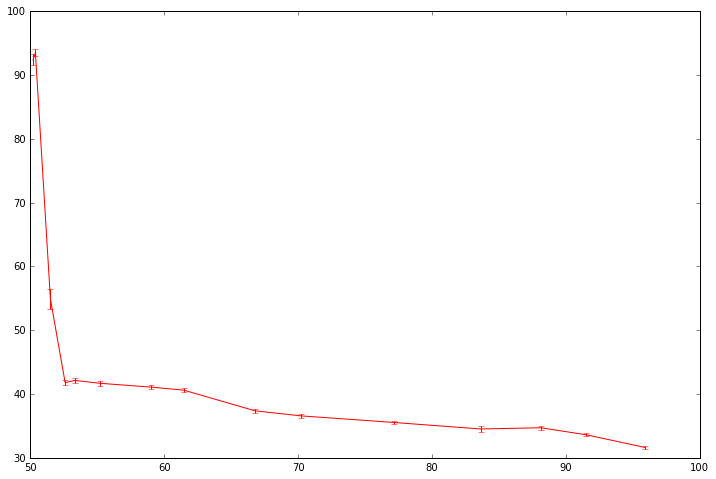

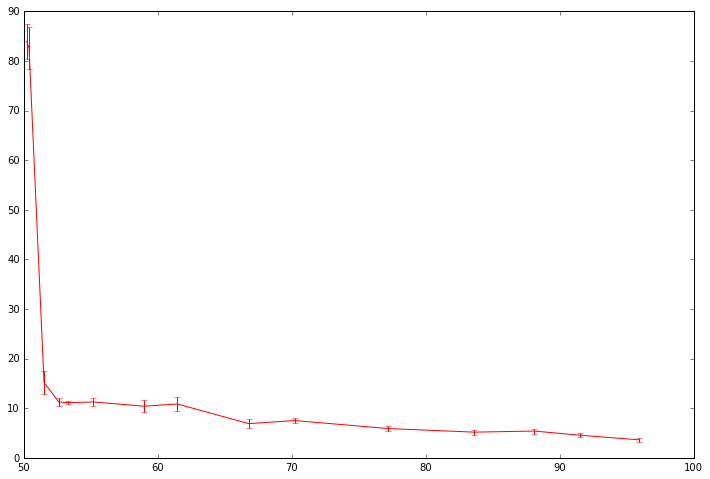

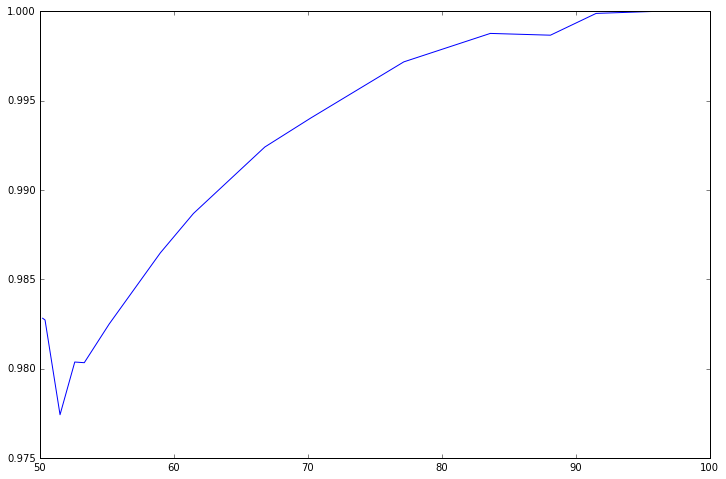

In [45]:
#cell 9
# GOAL 1: vary perceptual parameters and conclude that as uncertainty increases, there are more trials with velocity 1

perceptual_params_Table = np.zeros((15,4))
weighted_unc = np.zeros((15))

#50.2%
k_s = 1
k_o = 2
k_d = 1
alpha = 10
perceptual_params_Table[0,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[0] = 50.2

#50.38%
k_s = 0.5
k_o = 1
k_d = 0.5
alpha = 5
perceptual_params_Table[1,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[1] = 50.38

#51.5
k_s = 0.1
k_o = 0.5
k_d = 0.1
alpha = 1
perceptual_params_Table[2,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[2] = 51.5

#52.6%
k_s = 0.05
k_o = 0.1
k_d = 0.1
alpha = 0.5
perceptual_params_Table[3,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[3] = 52.6

#53.31
k_s = 0.03
k_o = 0.05
k_d = 0.1
alpha = 0.3
perceptual_params_Table[4,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[4] = 53.31

#55.17
k_s = 0.01
k_o = 0.1
k_d = 0.05
alpha = 0.3
perceptual_params_Table[5,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[5] = 55.17

#58.99
k_s = 0.01
k_o = 0.1
k_d = 0.01
alpha = 0.3
perceptual_params_Table[6,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[6] = 58.99

#61.46
k_s = 0.01
k_o = 0.05
k_d = 0.01
alpha = 0.1
perceptual_params_Table[7,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[7] = 61.46

#66.79%
k_s = 0.00131
k_o = 0.0024
k_d = 0.0129
alpha = 0.368
perceptual_params_Table[8,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[8] = 66.79

#70.21
k_s = 0.001
k_o = 0.002
k_d = 0.01
alpha = 0.2
perceptual_params_Table[9,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[9] = 70.21

#77.17
k_s = 0.001
k_o = 0.001
k_d = 0.005
alpha = 0.1
perceptual_params_Table[10,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[10] = 77.17

#83.63%
k_s = 0.001
k_o = 0.001
k_d = 0.002
alpha = 0.1
perceptual_params_Table[11,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[11] = 83.63

#88.21%
k_s = 0.0001
k_o = 0.0001
k_d = 0.003
alpha = 0.1
perceptual_params_Table[12,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[12] = 88.12

#91.53
k_s = 0.0001
k_o = 0.0001
k_d = 0.001
alpha = 0.05
perceptual_params_Table[13,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[13] = 91.53

#95.9
k_s = 0.00001
k_o = 0.00001
k_d = 0.0001
alpha = 0.005
perceptual_params_Table[14,:] = np.array([k_s, k_o, k_d, alpha]).copy()
weighted_unc[14] = 95.9

a,b = perceptual_params_Table.shape

k_s = 0.000000001
k_o = 0.00000001
k_d = 0.0000001
alpha = 0.000005
perceptual_params_Table[14,:] = np.array([k_s, k_o, k_d, alpha]).copy()

percept_params = [k_s, k_o, k_d, alpha]
dist_left_original = 0.15
accuracy_total = np.zeros((a))
mean_p_velocities = np.zeros((a,3))
variance_p_velocities = np.zeros((a,3))
mean_p_velocities_lastTrials = np.zeros((a,3))
variance_p_velocities_lastTrials = np.zeros((a,3))

mean_taus = np.zeros((a))
mean_Revidence = np.zeros((a))
number_steps = np.zeros((a))

for j in range(0,a):
    print "j", j   
    
    for i in range(0,10):
        print i

        [percentage_velocities, percentage_velocities_lastTrials, correctness, accuracy, meanTaus, tau_avg1, meanRevidence, numberSteps, value, policy, jump, percent_jump, percent_jump_atZero] = Simulate_N_pomdp(dist_left_original, perceptual_params_Table[j,:])
        
        sum_t = percentage_velocities[1] + percentage_velocities[2]
        mean_p_velocities[j,1] = mean_p_velocities[j,1] + percentage_velocities[1]/sum_t
        mean_p_velocities[j,2] = mean_p_velocities[j,2] + percentage_velocities[2]/sum_t
        variance_p_velocities[j,1] = variance_p_velocities[j,1] + (percentage_velocities[1]/sum_t)**2
        variance_p_velocities[j,2] = variance_p_velocities[j,2] + (percentage_velocities[2]/sum_t)**2
    
        sum_t = percentage_velocities_lastTrials[1] + percentage_velocities_lastTrials[2]
        mean_p_velocities_lastTrials[j,1] = mean_p_velocities_lastTrials[j,1] + percentage_velocities_lastTrials[1]/sum_t
        mean_p_velocities_lastTrials[j,2] = mean_p_velocities_lastTrials[j,2] + percentage_velocities_lastTrials[2]/sum_t
        variance_p_velocities_lastTrials[j,1] = variance_p_velocities_lastTrials[j,1] + (percentage_velocities_lastTrials[1]/sum_t)**2
        variance_p_velocities_lastTrials[j,2] = variance_p_velocities_lastTrials[j,2] + (percentage_velocities_lastTrials[2]/sum_t)**2
    
        accuracy_total[j] = accuracy_total[j] + accuracy
     
        mean_taus[j] = mean_taus[j] + mean(meanTaus)
        mean_Revidence[j] = mean_Revidence[j] + meanRevidence
        number_steps[j] = number_steps[j] + numberSteps
    
    variance_p_velocities[j,1] = variance_p_velocities[j,1]/10 - (mean_p_velocities[j,1]/10)**2
    variance_p_velocities[j,2] = variance_p_velocities[j,2]/10 - (mean_p_velocities[j,2]/10)**2
        
    mean_p_velocities[j,:] = mean_p_velocities[j,:]*10
    variance_p_velocities[j,:] = variance_p_velocities[j,:]*10000
 
    variance_p_velocities_lastTrials[j,1] = variance_p_velocities_lastTrials[j,1]/10 - (mean_p_velocities_lastTrials[j,1]/10)**2
    variance_p_velocities_lastTrials[j,2] = variance_p_velocities_lastTrials[j,2]/10 - (mean_p_velocities_lastTrials[j,2]/10)**2
        
    mean_p_velocities_lastTrials[j,:] = mean_p_velocities_lastTrials[j,:]*10
    variance_p_velocities_lastTrials[j,:] = variance_p_velocities_lastTrials[j,:]*10000
 
    accuracy_total[j] = accuracy_total[j]/10
        
    mean_taus[j] = mean_taus[j]/10
    mean_Revidence[j] = mean_Revidence[j]/10
    number_steps[j] = number_steps[j]/10
 

print "means", mean_p_velocities
print "variances", variance_p_velocities

print "accuracy", accuracy_total

print "mean taus", mean_taus
print "R evidence", mean_Revidence
print "number of steps", number_steps

fig = plt.figure(figsize=(12, 8))
plt.errorbar(weighted_unc, mean_p_velocities[:,1], yerr = np.sqrt(variance_p_velocities[:,1]), color = 'r')

fig = plt.figure(figsize=(12, 8))
plt.errorbar(weighted_unc, mean_p_velocities_lastTrials[:,1], yerr = np.sqrt(variance_p_velocities_lastTrials[:,1]), color = 'r')

fig = plt.figure(figsize = (12, 8))
plt.errorbmar(weighted_unc, accuracy_total, color = 'b')

plt.show()

0 0.05
0
1
2
3
4
5
6
7
8
9
1 0.1
0
1
2
3
4
5
6
7
8
9
2 0.15
0
1
2
3
4
5
6
7
8
9
3 0.2
0
1
2
3
4
5
6
7
8
9
4 0.25
0
1
2
3
4
5
6
7
8
9
5 0.3
0
1
2
3
4
5
6
7
8
9
6 0.35
0
1
2
3
4
5
6
7
8
9
7 0.4
0
1
2
3
4
5
6
7
8
9
8 0.45
0
1
2
3
4
5
6
7
8
9
9 0.5
0
1
2
3
4
5
6
7
8
9
10 0.55
0
1
2
3
4
5
6
7
8
9
11 0.6
0
1
2
3
4
5
6
7
8
9
12 0.65
0
1
2
3
4
5
6
7
8
9
13 0.7
0
1
2
3
4
5
6
7
8
9
14 0.75
0
1
2
3
4
5
6
7
8
9
15 0.8
0
1
2
3
4
5
6
7
8
9
means [[  0.          86.10910705  13.89089295]
 [  0.          54.1161494   45.8838506 ]
 [  0.          42.63496421  57.36503579]
 [  0.          36.35905025  63.64094975]
 [  0.          32.12486615  67.87513385]
 [  0.          29.57006227  70.42993773]
 [  0.          28.39971061  71.60028939]
 [  0.          28.74216139  71.25783861]
 [  0.          30.48630888  69.51369112]
 [  0.          33.36417839  66.63582161]
 [  0.          37.53482927  62.46517073]
 [  0.          40.49496942  59.50503058]
 [  0.          42.77478871  57.22521129]
 [  0.          43

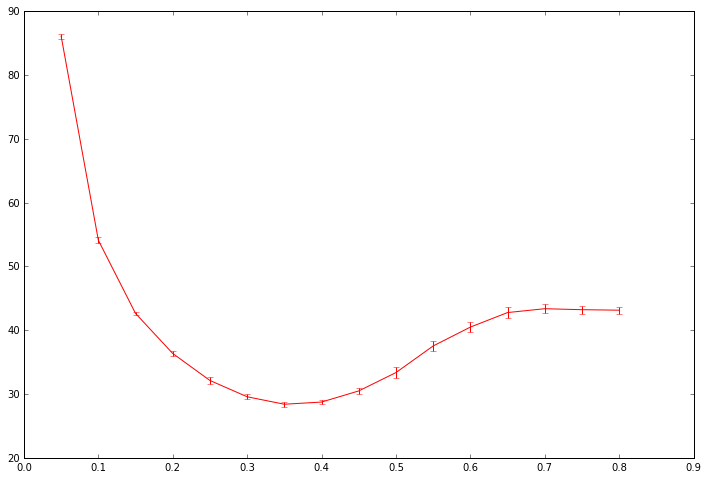

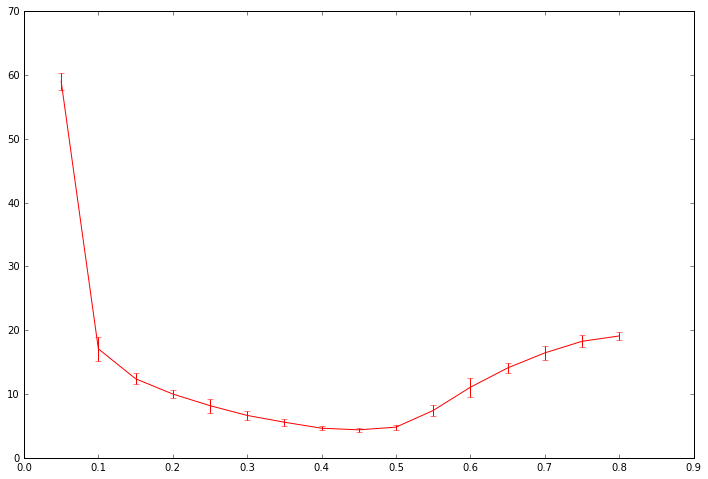

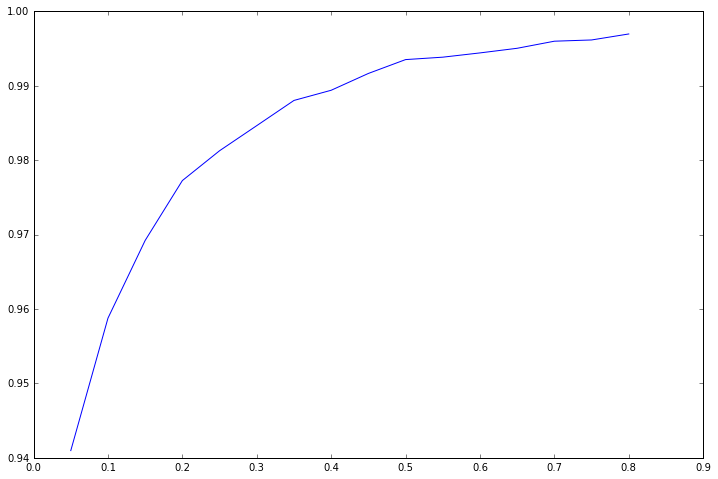

In [50]:
#cell 10
#GOAL 2: with increasing distance more trials when higher velocity 2 is selected

#66.79%
#k_s = 0.00131
#k_o = 0.0024
#k_d = 0.0129
#alpha = 0.368

k_s = -0.04754165
k_o = 0.10136526
k_d = 0.67576664
alpha = 0.09753478

perceptual_params = [k_s, k_o, k_d, alpha]
dist_left_original = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
#dist_left_original = np.array([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
a = dist_left_original.shape[0]
accuracy_total = np.zeros((a))
mean_p_velocities = np.zeros((a,3))
variance_p_velocities = np.zeros((a,3))
mean_p_velocities_lastTrials = np.zeros((a,3))
variance_p_velocities_lastTrials = np.zeros((a,3))

mean_taus = np.zeros((a))
mean_Revidence = np.zeros((a))
number_steps = np.zeros((a))

for j in range(0,a):
 print j, dist_left_original[j]   
    
 for i in range(0,10):
    print i
    
    [percentage_velocities, percentage_velocities_lastTrials, correctness, accuracy, meanTaus, tau_avg1, meanRevidence, numberSteps, value, policy, jump, percent_jump, percent_jump_atZero] = Simulate_N_pomdp(dist_left_original[j], perceptual_params)
        
    sum_t = percentage_velocities[1] + percentage_velocities[2]
    mean_p_velocities[j,1] = mean_p_velocities[j,1] + percentage_velocities[1]/sum_t
    mean_p_velocities[j,2] = mean_p_velocities[j,2] + percentage_velocities[2]/sum_t
    variance_p_velocities[j,1] = variance_p_velocities[j,1] + (percentage_velocities[1]/sum_t)**2
    variance_p_velocities[j,2] = variance_p_velocities[j,2] + (percentage_velocities[2]/sum_t)**2
    
    sum_t = percentage_velocities_lastTrials[1] + percentage_velocities_lastTrials[2]
    mean_p_velocities_lastTrials[j,1] = mean_p_velocities_lastTrials[j,1] + percentage_velocities_lastTrials[1]/sum_t
    mean_p_velocities_lastTrials[j,2] = mean_p_velocities_lastTrials[j,2] + percentage_velocities_lastTrials[2]/sum_t
    variance_p_velocities_lastTrials[j,1] = variance_p_velocities_lastTrials[j,1] + (percentage_velocities_lastTrials[1]/sum_t)**2
    variance_p_velocities_lastTrials[j,2] = variance_p_velocities_lastTrials[j,2] + (percentage_velocities_lastTrials[2]/sum_t)**2
    
    accuracy_total[j] = accuracy_total[j] + accuracy
    
    mean_taus[j] = mean_taus[j] + mean(meanTaus)
    mean_Revidence[j] = mean_Revidence[j] + meanRevidence
    number_steps[j] = number_steps[j] + numberSteps   
        
 variance_p_velocities[j,1] = variance_p_velocities[j,1]/10 - (mean_p_velocities[j,1]/10)**2
 variance_p_velocities[j,2] = variance_p_velocities[j,2]/10 - (mean_p_velocities[j,2]/10)**2
        
 mean_p_velocities[j,:] = mean_p_velocities[j,:]*10
 variance_p_velocities[j,:] = variance_p_velocities[j,:]*10000
 
 variance_p_velocities_lastTrials[j,1] = variance_p_velocities_lastTrials[j,1]/10 - (mean_p_velocities_lastTrials[j,1]/10)**2
 variance_p_velocities_lastTrials[j,2] = variance_p_velocities_lastTrials[j,2]/10 - (mean_p_velocities_lastTrials[j,2]/10)**2
        
 mean_p_velocities_lastTrials[j,:] = mean_p_velocities_lastTrials[j,:]*10
 variance_p_velocities_lastTrials[j,:] = variance_p_velocities_lastTrials[j,:]*10000
 
 accuracy_total[j] = accuracy_total[j]/10
  
 mean_taus[j] = mean_taus[j]/10
 mean_Revidence[j] = mean_Revidence[j]/10       
 number_steps[j] = number_steps[j]/10 
        
print "means", mean_p_velocities
print "variances", variance_p_velocities

print "accuracy", accuracy_total

print "mean taus", mean_taus
print "R evidence", mean_Revidence
print "number of steps", number_steps

fig = plt.figure(figsize=(12, 8))
plt.errorbar(dist_left_original, mean_p_velocities[:,1], yerr = np.sqrt(variance_p_velocities[:,1]), color = 'r')

fig = plt.figure(figsize=(12, 8))
plt.errorbar(dist_left_original, mean_p_velocities_lastTrials[:,1], yerr = np.sqrt(variance_p_velocities_lastTrials[:,1]), color = 'r')

fig = plt.figure(figsize = (12, 8))
plt.errorbar(dist_left_original, accuracy_total, color = 'b')

plt.show()